<a href="https://colab.research.google.com/github/Aleksandr62aa/Test_task/blob/main/FC_NN_diabetes_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of Diabetes**

**Dataset Diabetes**

**Importing libraries**

In [192]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.datasets
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MinMaxScaler
import csv
import cv2
from tqdm import tqdm

# Fixed seed
random.seed(9)
np.random.seed(9)
torch.manual_seed(9)
torch.cuda.manual_seed(9)
torch.backends.cudnn.deterministic = True

In [193]:
# Hyperparameters

# Training
num_epochs = 200
learning_rate = 1.0e-3

# Dataset
train_ratio = 0.8

# Model
input_size = 8
n_hidden_1 = 64
n_hidden_2 = 32
n_hidden_3 = 16
classes = 2

output_neurons = 2

**Train Test dataset**

In [194]:
class CustomDataset(Dataset):
    def __init__(self, tile_name):
        # read csv file
        file_out = pd.read_csv(tile_name)
        x = file_out.iloc[:,:-1].values
        y = file_out.iloc[:,-1].values
        # converting to torch tensors
        # scaler = MinMaxScaler()
        # x = scaler.fit_transform(x)
        self.X = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [195]:
dataset = CustomDataset('diabetes.csv')

In [196]:
# Define Split Ratios
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [197]:
print(len(train_data), len(test_data))
print(train_data[0], test_data[0])

614 154
(tensor([  1.0000, 109.0000,  60.0000,   8.0000, 182.0000,  25.4000,   0.9470,
         21.0000]), tensor(0)) (tensor([  0.0000, 100.0000,  70.0000,  26.0000,  50.0000,  30.8000,   0.5970,
         21.0000]), tensor(0))


In [198]:
train_dataloader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [199]:
for batch in train_dataloader :
    X_batch, y_batch = batch
    print( y_batch.sum())


tensor(202)


In [200]:
print(len(train_data), len(train_dataloader))
print(len(test_data), len(test_dataloader))

614 1
154 1


In [201]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

**Model FC NN**

In [202]:
class DiabedNet(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, n_hidden_1)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_1, n_hidden_2)
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_2, n_hidden_3)
        self.ac3 = torch.nn.ReLU()
        # self.drop_out = torch.nn.Dropout(p=0.2)
        self.fc4 = torch.nn.Linear(n_hidden_3, classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        return x

model = DiabedNet(input_size).to(device)

In [203]:
model

DiabedNet(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (ac3): ReLU()
  (fc4): Linear(in_features=16, out_features=2, bias=True)
)

**Loss function**

In [204]:
class_weights = torch.tensor([0.3, 0.7])  # веса
loss = torch.nn.CrossEntropyLoss(weight=class_weights)

**Optimizer**

In [205]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Training procedure**

In [206]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in tqdm(range(num_epochs)):   # цикл обучения по эпохам

    running_loss_train = 0.
    running_acc_train = 0.

    for batch in train_dataloader:# цикл обучения по бачам
        model.train()
        optimizer.zero_grad()
        X_batch, y_batch = batch

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_preds = model.forward(X_batch)

        # loss функция
        loss_train = loss(y_preds, y_batch)

        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.cpu().detach().numpy()
        running_acc_train += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()
    epoch_loss = running_loss_train/ len(train_dataloader)
    train_loss_history.append(epoch_loss)

    epoch_acc = running_acc_train/len(train_dataloader)
    train_accuracy_history .append(epoch_acc)

    # тестирование модели
    running_loss_test = 0.
    running_acc_test = 0.
    model.eval()

    for batch in test_dataloader:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_preds = model.forward(X_batch)

        running_loss_test += loss(y_preds, y_batch).cpu().detach().numpy()
        running_acc_test += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()

    epoch_loss = running_loss_test/len(test_dataloader)
    test_loss_history.append(epoch_loss)

    epoch_acc = running_acc_test/len(test_dataloader)
    test_accuracy_history.append(epoch_acc)


100%|██████████| 200/200 [00:03<00:00, 66.06it/s]


In [213]:
# Evaluate the model using PyTorch

y_true = []
y_pred = []
model.eval()

for batch in test_dataloader:
    X_batch, y_batch = batch
    X_batch = X_batch.to(device)
    outputs = model(X_batch)
    _, y_preds = torch.max(outputs, dim=1)
    y_pred.extend(y_preds.cpu().numpy())
    y_true.extend(y_batch.cpu().numpy())

# Convert lists to tensors for calculation
y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)

# Calculating precision, recall, and F1 score using PyTorch
TP = ((y_pred_tensor == 1) & (y_true_tensor == 1)).sum().item()
TN = ((y_pred_tensor == 0) & (y_true_tensor == 0)).sum().item()
FP = ((y_pred_tensor == 1) & (y_true_tensor == 0)).sum().item()
FN = ((y_pred_tensor == 0) & (y_true_tensor == 1)).sum().item()

accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0

precision_0 = TN / (TN + FN) if TN + FN > 0 else 0
precision_1 = TP / (TP + FP) if TP + FP > 0 else 0
recall_0 = TN / (TN + FP) if TN + FP > 0 else 0
recall_1 = TP / (TP + FN) if TP + FN > 0 else 0

f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision_0: {precision_0:.4f}, Precision_1: {precision_1:.4f}')
print(f'Recall_0: {recall_0:.4f}, Recall_1: {recall_1:.4f}')
print(f'F1-Score_0: {f1_0:.4f}, F1-Score_1: {f1_1:.4f}')

Accuracy: 0.7338
Precision_0: 0.8052, Precision_1: 0.6623
Recall_0: 0.7045, Recall_1: 0.7727
F1-Score_0: 0.7515, F1-Score_1: 0.7133


**Result test**

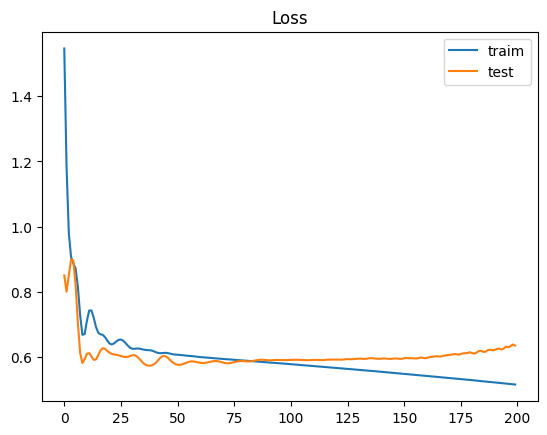

In [208]:
plt.plot(train_loss_history, label='traim')
plt.plot(test_loss_history, label='test')
plt.legend(loc='best')
plt.title('Loss');

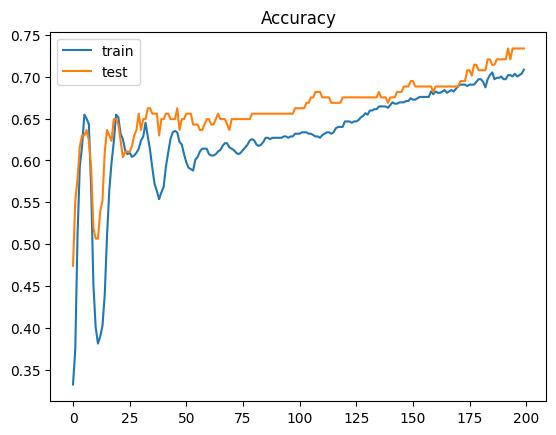

In [209]:
plt.plot(train_accuracy_history, label='train')
plt.plot(test_accuracy_history, label='test')
plt.legend(loc='best')
plt.title('Accuracy');

In [ ]:
# Save the model state
st = model.state_dict()
torch.save(st, 'diab_net.tar')
# torch.save(st, 'mnist_net.pth')

In [ ]:
# mnist_net.fc1.weight.data, mnist_net.fc1.bias.data

In [ ]:
##########################################################33